1. 実装した Attention 機構の意味

今回実装したのは、LLM 系 Sparse Attention（Longformer / BigBird 系）と同型の構造です。

Attention ルール

Local Attention
各トークンは「近傍 window_size 内」だけを見る

Global Attention
特定トークン（例：CLS）は

全トークンを見る

全トークンからも見られる

数式的イメージ
𝐴
𝑖
𝑗
=
{
allowed

∣
𝑖
−
𝑗
∣
≤
𝑤


allowed

𝑖
∈
𝐺
 or
𝑗
∈
𝐺


−
∞

otherwise
A
ij
	​

=
⎩
⎨
⎧
	​

allowed
allowed
−∞
	​

∣i−j∣≤w
i∈G or j∈G
otherwise
	​


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import vit_b_16
from PIL import Image
import torchvision.transforms as T

In [3]:
class SparseGlobalAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, window_size, global_indices):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.global_indices = global_indices

        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, x):
        B, T, D = x.shape
        device = x.device

        # Attention mask (T, T)
        attn_mask = torch.full((T, T), float("-inf"), device=device)

        for i in range(T):
            # Local window
            start = max(0, i - self.window_size)
            end = min(T, i + self.window_size + 1)
            attn_mask[i, start:end] = 0.0

            # Global tokens
            if i in self.global_indices:
                attn_mask[i, :] = 0.0
                attn_mask[:, i] = 0.0

        out, attn_weights = self.attn(
            x, x, x,
            attn_mask=attn_mask,
            need_weights=True,
            average_attn_weights=False
        )

        return out, attn_weights


In [4]:
B = 1
T = 32     # token length
D = 64
H = 4

x = torch.randn(B, T, D)

# token 0 = Global token (CLS-like)
model = SparseGlobalAttention(
    embed_dim=D,
    num_heads=H,
    window_size=2,
    global_indices=[0]
)


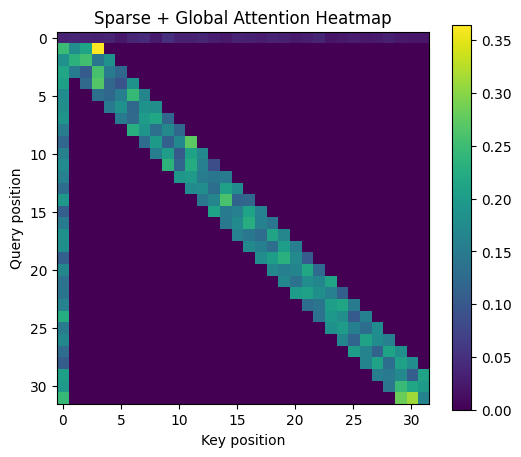

In [6]:
with torch.no_grad():
    out, attn = model(x)

attn_map = attn[0].mean(0)  # (T, T)

plt.figure(figsize=(6, 5))
plt.imshow(attn_map)
plt.title("Sparse + Global Attention Heatmap")
plt.xlabel("Key position")
plt.ylabel("Query position")
plt.colorbar()
plt.show()
